# Part 3  - Clément Royer (SGD)


dataset : https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?resource=download

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
from numpy.linalg import norm
%matplotlib inline

Question 1: Implement stochastic gradient and compare its performance with that of your gradient descent implementation from Part 1 on the same problem and dataset. What happens when both methods are run using the same stepsize? Do your observations confirm what has been discussed during the lecture?


In [205]:
data = pd.read_csv('./data/winequality-red.csv', sep=',')
data = data.drop_duplicates()
# copy the data
data_scaled = data.copy()
mean_data = data_scaled.mean()
std_data =  data_scaled.std()

# apply normalization techniques
for column in data_scaled.columns:
    if column!='MEDV':
        data_scaled[column] = (data_scaled[column] - mean_data[column]) / std_data[column]
    else : data_scaled[column] = (data_scaled[column] - mean_data[column]) / std_data[column]


df_label = data_scaled['quality']
df_features = data_scaled.drop(columns=['quality']) 

X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.33, random_state=42, shuffle = True)

A_test = X_test.to_numpy() #training matrix
Y_test = y_test.to_numpy() #label matrix
A_train = X_train.to_numpy() #training matrix
Y_train = y_train.to_numpy() #label matrix
p = X_train.shape[1] #number of feature
n = X_train.shape[0] #nb of data point
#x0 = np.random.rand(p).T #random initial point 
x0 = np.zeros((p))

In [206]:
def gradient_descent(x0, A, y, iterations = 60, learning_rate = 0.01, stopping_threshold = 1e-6):
    
    loss = [] #to return 
    log_opt_distance=[] #to record the distance to the optimal solution
    vector=x0 #starting point
    n,p = X_train.shape #nb of data point , nb feature
    
    #optimal solution 
    sol_vector = np.linalg.solve(A.transpose().dot(A), A.transpose().dot(y))
    prediction_opt = A.dot(sol_vector)
    error_opt = y - prediction_opt 
    mse_opt = (1/(2*n))*(np.dot(error_opt.T,error_opt))
    
    # Gradient descent iteration
    for _ in range(iterations):
        # Calculating the prediction : A*x
        prediction = A.dot(vector)
                
        #mean square error
        error = y - prediction 
        mse = (1/(2*n))*(np.dot(error.T,error)) 
        loss.append(mse)

        #log opti distance
        log_opt_distance.append(np.log(mse-mse_opt))
        
        #calcultating gradient
        grad = -(A.transpose().dot(error))/n
        
        #gradient descent step
        vector = vector - (learning_rate * grad)
        #previous_loss = mse
        # Printing the mse for each iteration
        #print(f"Iteration {i+1}: Cost {mse}")
    return vector, loss, log_opt_distance

In [207]:
def stoch_grad(x0,A,xtarget,stepchoice=0, step=1, lr=0.1 ,nb_epochs=60,nb=1,with_replace=False):
    # Initial value of current iterate  
    x = x0.copy()
    # Lipschitz constantA
    L = norm(A_train, ord=2) ** 2 
    # objective history
    objvals = []
    log_opt_dist=[]
    n,p = A.shape #nb of data point
    f = A.dot(x)
    #optimal solution 
    sol_vector = np.linalg.solve(A.transpose().dot(A), A.transpose().dot(xtarget))
    f_opt = A.dot(sol_vector)
    error_opt = xtarget -f_opt 
    obj_opt = (1/(2*n))*(np.dot(error_opt.T,error_opt))

    #mean square error
    error = xtarget - f
    obj =  (np.dot(error.T,error))/(2.*n)
    objvals.append(obj)
    # Main loop
    for k in range(int(nb_epochs*n/nb)): #n_iter = n_epoch*n/nb
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        sg = np.zeros(p)
        for j in range(nb):
            f_i = A[ik[j],:].dot(x)
            error = xtarget[ik[j]] - f_i
            gi = (-A[ik[j],:].transpose().dot(error))/nb
            sg = sg + gi
            
        if stepchoice==0:
            x[:] = x - (step/L) * sg
        elif stepchoice>0:
            sk = float(step/((k+1)**stepchoice))
            x[:] = x - sk * sg
        else :
            x[:] = x - lr * sg
        #x[:] = x - step*sg

        if (k*nb) % n == 0:
            f = A.dot(x)
            #mean square error
            error = xtarget - f
            obj =  (np.dot(error.T,error))/(2.*n)
            objvals.append(obj)
            log_opt_dist.append(obj-obj_opt)
    #output
    x_output = x.copy()

    return x_output, objvals, log_opt_dist



In [208]:
def stoch_grad_periter(x0,A,xtarget,stepchoice=0, step=1, lr=0.1 ,nb_iter=60,nb=1,with_replace=False):
    # Initial value of current iterate  
    x = x0.copy()
    # Lipschitz constant
    L = norm(A_train, ord=2) ** 2 
    # objective history
    objvals = []
    log_opt_dist=[]
    n,p = A.shape #nb of data point
    f = A.dot(x)
    #optimal solution 
    sol_vector = np.linalg.solve(A.transpose().dot(A), A.transpose().dot(xtarget))
    f_opt = A.dot(sol_vector)
    error_opt = xtarget -f_opt 
    obj_opt = (1/(2*n))*(np.dot(error_opt.T,error_opt))

    #mean square error
    error = xtarget - f
    obj =  (np.dot(error.T,error))/(2.*n)
    objvals.append(obj)
    # Main loop
    for k in range(nb_iter): #n_iter = n_epoch*n/nb
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        sg = np.zeros(p)
        for j in range(nb):
            f_i = A[ik[j],:].dot(x)
            error = xtarget[ik[j]] - f_i
            gi = (-A[ik[j],:].transpose().dot(error))/nb
            sg = sg + gi
            
        if stepchoice==0:
            x[:] = x - (step/L) * sg
        elif stepchoice>0:
            sk = float(step/((k+1)**stepchoice))
            x[:] = x - sk * sg
        else:
            x[:] = x - lr * sg
        #x[:] = x - step*sg

        f = A.dot(x)
        #mean square error
        error = xtarget - f
        obj =  (np.dot(error.T,error))/(2.*n)
        objvals.append(obj)
        log_opt_dist.append(obj-obj_opt)
    #output
    x_output = x.copy()

    return x_output, objvals, log_opt_dist



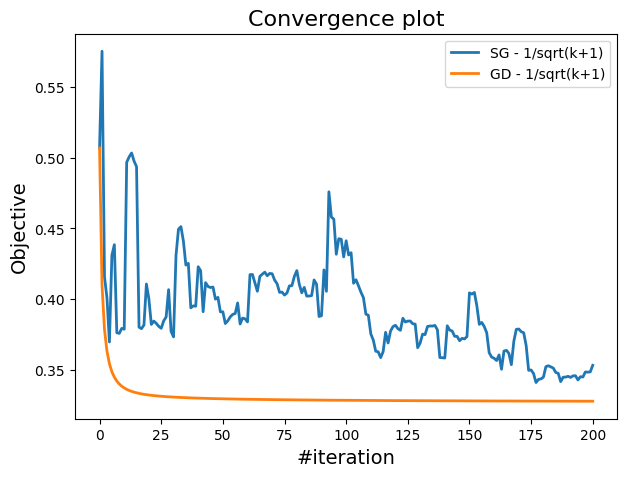

In [209]:
# Plot the comparison of variants of GD/SG with the same stepsize rule
# NB: The x-axis is in iteration (1 iteration of GD).

np.random.seed(123)

#starting with a random vector
n,p = X_train.shape #nb of data point, number of feature


x0 = np.zeros((p))




plt.figure(figsize=(7, 5))

# final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=0 , step=1, nb_iter=200)
# plt.plot(loss, label="SG - 1/L", lw=2)
final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=0.5 , step=0.2, nb_iter=200)
plt.plot(loss, label="SG - 1/sqrt(k+1)", lw=2)
# final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=0 , step=1, nb_iter=200, nb=n)
# plt.plot(loss, label="GD - 1/L", lw=2)
final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=0.5 , step=0.2, nb_iter=200, nb=n)
plt.plot(loss, label="GD - 1/sqrt(k+1)", lw=2)
#plt.semilogy(loss, label='GD ')
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iteration", fontsize=14)
plt.ylabel("Objective", fontsize=14)
plt.legend()


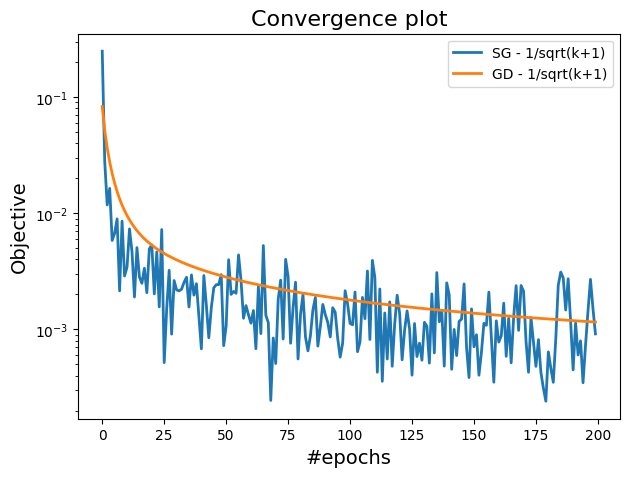

In [174]:
# Plot the comparison of variants of GD/SG with the same stepsize rule
# NB: The x-axis is in epochs (1 iteration of GD).

np.random.seed(123)

#starting with a random vector
n,p = X_train.shape #nb of data point, number of feature


x0 = np.zeros((p))
#collection losses for different fixe step size




plt.figure(figsize=(7, 5))

# final_x , loss, log_dist = stoch_grad(x0, A_train , Y_train, stepchoice=0 , step=1, nb_epochs=200)
# plt.semilogy(log_dist, label="SG - 1/L", lw=2)
final_x , loss, log_dist = stoch_grad(x0, A_train , Y_train, stepchoice=0.5 , step=0.2, nb_epochs=200)
plt.semilogy(log_dist, label="SG - 1/sqrt(k+1)", lw=2)
# final_x , loss, log_dist = stoch_grad(x0, A_train , Y_train, stepchoice=0 , step=1, nb_epochs=200, nb=n)
# plt.semilogy(log_dist, label="GD - 1/L", lw=2)
final_x , loss, log_dist = stoch_grad(x0, A_train , Y_train, stepchoice=0.5 , step=0.2, nb_epochs=200, nb=n)
plt.semilogy(log_dist, label="GD - 1/sqrt(k+1)", lw=2)
#plt.semilogy(loss, label='GD ')
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objective", fontsize=14)
plt.legend()


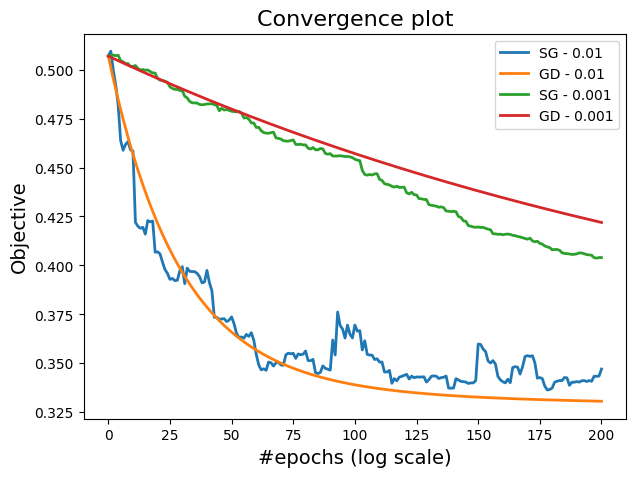

In [170]:
# Plot the comparison of variants of GD/SG with the same stepsize rule
# NB: The x-axis is in epochs (1 iteration of GD).

np.random.seed(123)

#starting with a random vector
n,p = X_train.shape #nb of data point, number of feature


x0 = np.zeros((p))
#collection losses for different fixe step size




plt.figure(figsize=(7, 5))
mult_lr = [0.01,0.001]
for tau in mult_lr:
    final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , lr=tau, nb_iter=200, nb=1)
    plt.plot(loss, label="SG - "+str(tau), lw=2)
    final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , lr=tau, nb_iter=200, nb=n)
    plt.plot(loss, label="GD - "+str(tau), lw=2)

#plt.semilogy(loss, label='GD ')
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective", fontsize=14)
plt.legend()


### Question 2: Find a value for the batch size that realizes a good compromise between gradient descent and stochastic gradient.

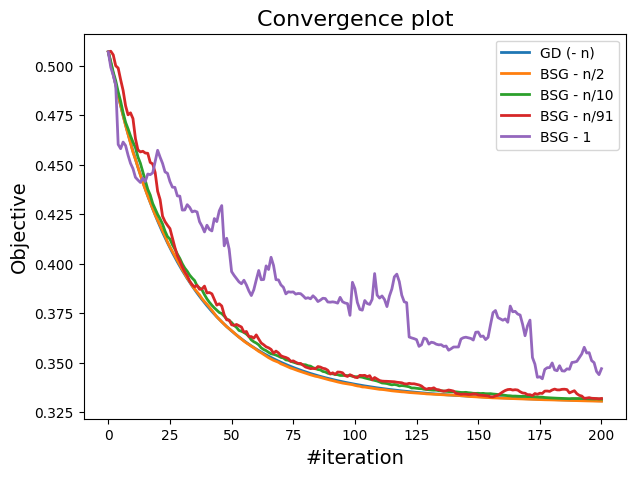

In [198]:
# Test several values for the batch size using the same epoch budget.

#starting with a random vector
n,p = X_train.shape #number of feature #nb of data point
batchs =  [int(n/91), int(n/10), int(n/2), int(n)]
x0 = np.zeros((p))
#collection losses for different fixe step size

plt.figure(figsize=(7, 5))

final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , step=0.2,lr=0.01, nb_iter=200, nb=n)
plt.plot(loss, label="GD (- n)", lw=2)
final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , step=0.2,lr=0.01, nb_iter=200, nb=int(n/2))
plt.plot(loss, label="BSG - n/2", lw=2)
final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , step=0.2,lr=0.01, nb_iter=200, nb=int(n/10))
plt.plot(loss, label="BSG - n/10", lw=2)
final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , step=0.2,lr=0.01, nb_iter=200, nb=int(n/91))
plt.plot(loss, label="BSG - n/91", lw=2)
final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , step=0.2, lr=0.01, nb_iter=200)
plt.plot(loss, label="BSG - 1", lw=2)

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iteration", fontsize=14)
plt.ylabel("Objective", fontsize=14)
plt.legend()

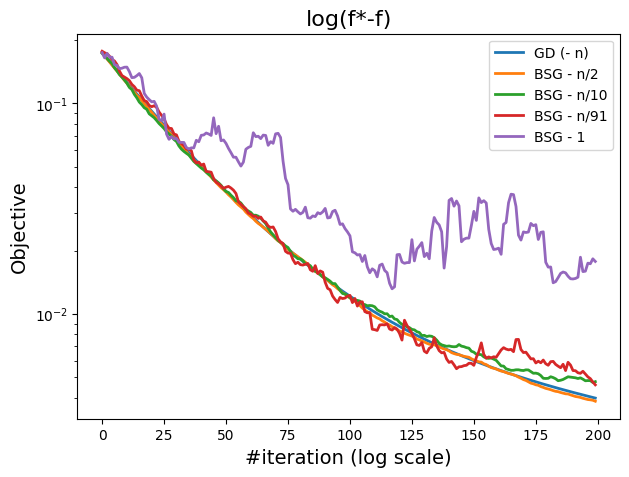

In [189]:
# Test several values for the batch size using the same epoch budget.

#starting with a random vector
n,p = X_train.shape #number of feature #nb of data point
batchs =  [int(n/91), int(n/10), int(n/2), int(n)]
x0 = np.zeros((p))
#collection losses for different fixe step size

plt.figure(figsize=(7, 5))

final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , step=0.2,lr=0.01, nb_iter=200, nb=n)
plt.semilogy(log_dist, label="GD (- n)", lw=2)
final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , step=0.2,lr=0.01, nb_iter=200, nb=int(n/2))
plt.semilogy(log_dist, label="BSG - n/2", lw=2)
final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , step=0.2,lr=0.01, nb_iter=200, nb=int(n/10))
plt.semilogy(log_dist, label="BSG - n/10", lw=2)
final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , step=0.2,lr=0.01, nb_iter=200, nb=int(n/91))
plt.semilogy(log_dist, label="BSG - n/91", lw=2)
final_x , loss, log_dist = stoch_grad_periter(x0, A_train , Y_train, stepchoice=-1 , step=0.2, lr=0.01, nb_iter=200)
plt.semilogy(log_dist, label="BSG - 1", lw=2)

plt.title("log(f*-f)", fontsize=16)
plt.xlabel("#iteration", fontsize=14)
plt.ylabel("Objective", fontsize=14)
plt.legend()

n/10 seems to be a good compromize

### Question 3: Compare your stochastic gradient method with one of the advanced variants seen in class on your selected problem. Discuss your results, and what interpretation you can draw from them.

In [140]:
def GD_Momemtum(x0, A, y,beta, iterations = 60, stopping_threshold = 1e-6, stepchoice=0.5 , step=0.2):

    # Initializing learning rate and iterations
    loss = [] #to return 
    past_x = [] #to return
    log_opt_dist = []
    vector=x0 #starting point 
    past_vector=x0.copy() #for x(t-1)
    n = X_train.shape[0] #nb of data point
    #optimal solution 
    sol_vector = np.linalg.solve(A.transpose().dot(A), A.transpose().dot(y))
    prediction_opt = A.dot(sol_vector)
    error_opt = y - prediction_opt 
    mse_opt = (1/(2*n))*(np.dot(error_opt.T,error_opt))
    # Estimation of optimal parameters
    for k in range(iterations):
        # Calculating a new prediction
        prediction = A.dot(vector)
        #mean square error
        error = y - prediction 
        mse = (1/(2*n))*(np.dot(error.T,error))
        loss.append(mse)
        log_opt_dist.append(mse-mse_opt)
        #calcultating gradient
        grad = -(A.transpose().dot(error))/n
        tmp=vector.copy()
        #gradient descent step
        sk = float(step/((k+1)**stepchoice))
        vector = vector - (sk * grad) + beta*(vector - past_vector)
        past_vector = tmp
        # Printing the mse for each iteration
        #print(f"Iteration {i+1}: Cost {mse}")

    return vector, loss, log_opt_dist

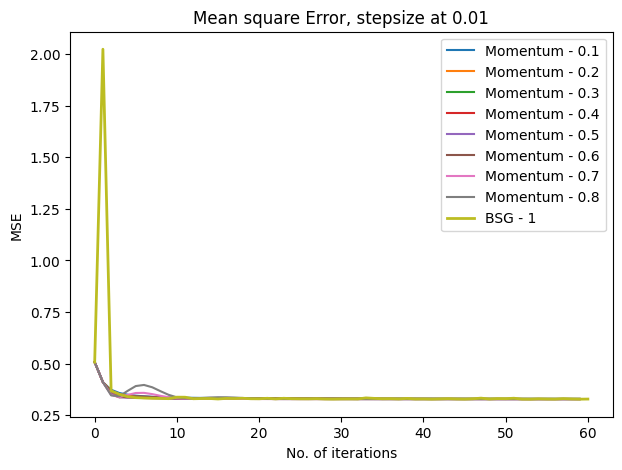

In [142]:
plt.figure(figsize=(7, 5))
x0 = np.zeros((p))
beta_mult = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for beta in beta_mult:
    final_x , loss, log_dist = GD_Momemtum(x0, A_train , Y_train, beta=beta,stepchoice=0.5 , step=0.2)
    plt.plot(loss, label='Momentum - ' +str(beta))
final_x , loss, log_dist = stoch_grad(x0, A_train , Y_train, stepchoice=0.5 , step=0.2, nb_epochs=60)
plt.plot(loss, label="BSG - 1", lw=2)
plt.title('Mean square Error, stepsize at 0.01')
plt.xlabel('No. of iterations')
plt.ylabel('MSE')
plt.legend()
plt.show()

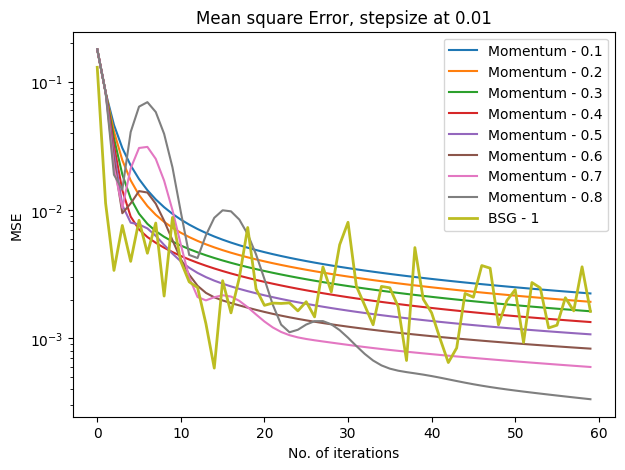

In [143]:
plt.figure(figsize=(7, 5))
x0 = np.zeros((p))
beta_mult = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for beta in beta_mult:
    final_x , loss, log_dist = GD_Momemtum(x0, A_train , Y_train, beta=beta,stepchoice=0.5 , step=0.2)
    plt.semilogy(log_dist, label='Momentum - ' +str(beta))
final_x , loss, log_dist = stoch_grad(x0, A_train , Y_train, stepchoice=0.5 , step=0.2, nb_epochs=60)
plt.semilogy(log_dist, label="BSG - 1", lw=2)
plt.title('Mean square Error, stepsize at 0.01')
plt.xlabel('No. of iterations')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [149]:
def SGD_it_avg(x0, A, y, epochs = 60, nb=1 , stopping_threshold = 1e-6, stepchoice=0.5 , step=0.2):
    # Initializing learning rate and iterations
    loss = [] #to return
    log_dist=[]
    vectors = [x0.copy()] #to return
    vector=x0.copy() #starting point
    n,p = A.shape #nb of data point
    #optimal solution 
    sol_vector = np.linalg.solve(A.transpose().dot(A), A.transpose().dot(y))
    prediction_opt = A.dot(sol_vector)
    error_opt = y - prediction_opt 
    mse_opt = (1/(2*n))*(np.dot(error_opt.T,error_opt))
    
    # Estimation of optimal parameters
    for k in range(epochs):
        ik = np.random.choice(n,nb,replace=False)
        sg = np.zeros(p)
        for j in range(nb):
            f_i = A[ik[j],:].dot(vector)
            error = y[ik[j]] - f_i
            gi = (-A[ik[j],:].transpose().dot(error))/nb
            sg = sg + gi
        #mean square error
        error = prediction - y[ik] 
        mse = 1/(2*nb) *(np.dot(error.T,error))
        loss.append(mse)
        log_dist.append(mse-mse_opt)
        #calcultating gradient
        grad_k = (1/nb)*A[ik,:].transpose().dot(error)

        #gradient descent step
        sk = float(step/((k+1)**stepchoice))
        last_vector = vectors[-1] - (sk * grad_k)
        vectors.append(last_vector)
        vector = np.mean(vectors, axis=0)

    return vector, loss, log_dist

In [ ]:
def stoch_grad_avg(x0,A,xtarget,stepchoice=0, step=1 ,nb_epochs=60,nb=1,with_replace=False):
    # Initial value of current iterate  
    x = x0.copy()
    # Lipschitz constant
    L = norm(A_train, ord=2) ** 2 
    # objective history
    objvals = []
    log_opt_dist=[]
    vectors = []
    n,p = A.shape #nb of data point
    f = A.dot(x)
    #optimal solution 
    sol_vector = np.linalg.solve(A.transpose().dot(A), A.transpose().dot(xtarget))
    f_opt = A.dot(sol_vector)
    error_opt = xtarget -f_opt 
    obj_opt = (1/(2*n))*(np.dot(error_opt.T,error_opt))

    #mean square error
    error = xtarget - f
    obj =  (np.dot(error.T,error))/(2.*n)
    objvals.append(obj)
    # Main loop
    for k in range(int(nb_epochs*n/nb)): #n_iter = n_epoch*n/nb
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        sg = np.zeros(p)
        for j in range(nb):
            f_i = A[ik[j],:].dot(x)
            error = xtarget[ik[j]] - f_i
            gi = (-A[ik[j],:].transpose().dot(error))/nb
            sg = sg + gi

        sk = float(step/((k+1)**stepchoice))
        #x[:] = x - sk * sg
        x = x - (sk * sg)
        vectors.append(x)
        x = np.mean(vectors, axis=0)
        #x[:] = x - step*sg

        if (k*nb) % n == 0:
            f = A.dot(x)
            #mean square error
            error = xtarget - f
            obj =  (np.dot(error.T,error))/(2.*n)
            objvals.append(obj)
            log_opt_dist.append(obj-obj_opt)
    #output
    x_output = x.copy()

    return x_output, objvals, log_opt_dist



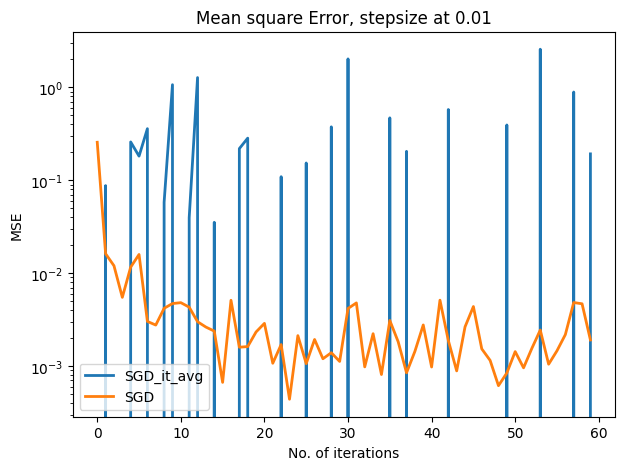

In [ ]:
plt.figure(figsize=(7, 5))
x0 = np.zeros((p))
final_x , loss, log_dist = stoch_grad_avg(x0, A_train , Y_train, stepchoice=0.5 , step=0.2)
plt.semilogy(log_dist, label="SGD_it_avg", lw=2)
final_x , loss, log_dist = stoch_grad(x0, A_train , Y_train, stepchoice=0.5 , step=0.2, nb_epochs=60)
plt.semilogy(log_dist, label="SGD", lw=2)
plt.title('Mean square Error, stepsize at 0.01')
plt.xlabel('No. of iterations')
plt.ylabel('MSE')
plt.legend()
plt.show()